In [ ]:
# things become crazy if the distances change

In [1]:
import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')

from bt_tools import BDE
import utils_qm as uqm
import numpy as np
from matplotlib import pyplot as plt
import glob
import ase.io as aio
from ase.units import Bohr

In [2]:
def key2(x):
    pattern_list = ['CC', 'CN', 'CO', 'CF', 'NN', 'NO', 'NF', 'OO', 'OF', 'FF']
    for i, p in enumerate(pattern_list):
        if p in x:
            return(i)
def key3(x):
    pattern_list = ['[GeH3][GeH3]', '[GeH3][AsH2]', '[GeH3][SeH]', '[GeH3]Br', '[AsH2][AsH2]', '[AsH2][SeH]', '[AsH2]Br', '[SeH][SeH]', '[SeH]Br', 'BrBr']
    for i, p in enumerate(pattern_list):
        if p in x:
            return(i)
def key4(x):
    pattern_list = ['[GeH3][GeH3]', '[GeH3][AsH2]', '[GeH3][SeH]', '[GeH3]Br', '[AsH2][AsH2]', '[AsH2][SeH]', '[AsH2]Br', '[SeH][SeH]', '[SeH]Br', 'BrBr']
    for i, p in enumerate(pattern_list):
        if p in x:
            return(i)
        
def get_exact_np(structures):
    exact_np = []
    for s in structures:
        mol = aio.read(s)
        Z1, Z2 = mol.get_atomic_numbers()[0], mol.get_atomic_numbers()[1]
        d = mol.get_distance(0, 1)/Bohr
        exact_np.append(Z1*Z2/d)
    exact_np = np.array(exact_np)
    return(exact_np)    

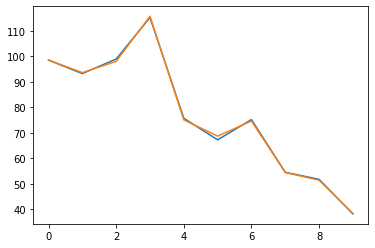

In [3]:
BDE_models = dict()
# nbfe with av dist and no hydrogen
energies = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_2/energies_single.txt')
nuc_charges = [6, 7, 8, 9]
dh = BDE(energies, nuc_charges)
BDE_models['dh'] = dh

dh.linear_fit()
plt.plot(dh.bde)
plt.plot(dh.bde_predicted)

In [4]:
dh.linear_mae

0.5134766713006712

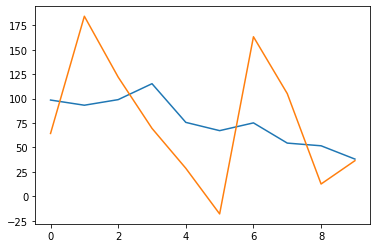

In [5]:
# nbfe with exact distance and no hydrogen
row = 'row_2'
system = 'diatomics'
bond_type = 'single'
fname = '*_opt.xyz'

structures = glob.glob(f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/{row}/{system}_{bond_type}/{fname}')
structures.sort(key=key2)
exact_np = get_exact_np(structures)

energies_enp = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_2/energies_single.txt')
energies_enp[:,1] = energies_enp[:,0]-exact_np
energies_enp[:,2] = exact_np
Dh = BDE(energies_enp, nuc_charges)
BDE_models['Dh'] = Dh

Dh.linear_fit()
plt.plot(Dh.bde)
plt.plot(Dh.bde_predicted)

In [6]:
Dh.linear_mae

50.53933074277721

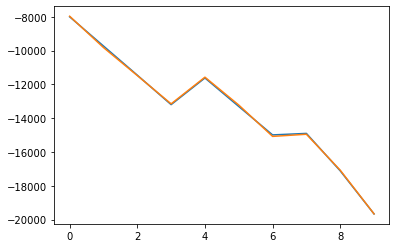

In [7]:
plt.plot(Dh.ebfe)
plt.plot(Dh.ebfe_predicted)

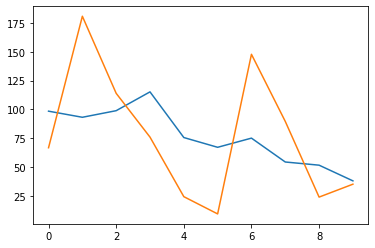

In [8]:
# nbfe with exact distance and hydrogen
def get_nuc_rep(xyz_file):
    atoms = aio.read(xyz_file)
    nuc_rep = 0
    for i in range(len(atoms)):
        for j in range(i+1, len(atoms)):
            nuc_rep += atoms.get_atomic_numbers()[i]*atoms.get_atomic_numbers()[j]/atoms.get_distance(i, j)*Bohr
    return(nuc_rep)

# calculate nuc rep
row = 'row_2'
system = 'diatomics'
bond_type = 'single'
fname = '*_opt.xyz'

frag_nrep = {'C':0, 'N':0, 'O':0, 'F':0}
for k in frag_nrep.keys():
    path = f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_2/fragments_single/{k}{k}_opt.xyz'
    frag_nrep[k] = get_nuc_rep(path)

structures = glob.glob(f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/{row}/{system}_{bond_type}/{fname}')
structures.sort(key=key2)
nrep = []
for s in structures:
    e_rep = get_nuc_rep(s)
    smiles = s.split('/')[-1].split('_')[0]
    frag1, frag2 = uqm.fragmentize_smiles(smiles)
    nrep.append(e_rep - frag_nrep[frag1] - frag_nrep[frag2])
nrep = np.array(nrep)
# load data
energies_dh = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_2/energies_single.txt')
energies_dh[:,1] = energies_dh[:,0] - nrep
energies_dh[:,2] = nrep
DH = BDE(energies_dh, nuc_charges)
BDE_models['DH'] = DH

DH.linear_fit()
plt.plot(DH.bde)
plt.plot(DH.bde_predicted)

In [9]:
DH.linear_mae

42.057629468823066

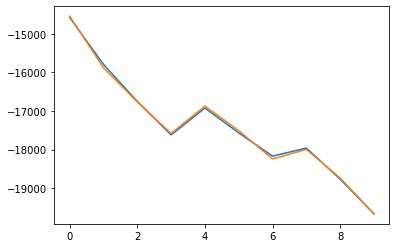

In [10]:
plt.plot(DH.ebfe)
plt.plot(DH.ebfe_predicted)

In [11]:
# nbfe with av dist and hydrogen

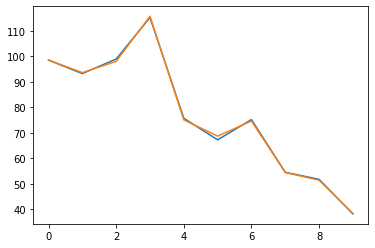

In [12]:
# nbfe with exact distance and hydrogen
def get_nuc_rep_av(xyz_file):
    atoms = aio.read(xyz_file)
    nuc_rep = 0
    for i in range(len(atoms)):
        for j in range(i+1, len(atoms)):
            if atoms.get_atomic_numbers()[i] == 1 or atoms.get_atomic_numbers()[j] == 1:
                d = 1.0393044393092186
            else:
                d = 1.420926045111333
            nuc_rep += atoms.get_atomic_numbers()[i]*atoms.get_atomic_numbers()[j]/d*Bohr
    return(nuc_rep)

# calculate nuc rep
row = 'row_2'
system = 'diatomics'
bond_type = 'single'
fname = '*_opt.xyz'

frag_nrep = {'C':0, 'N':0, 'O':0, 'F':0}
for k in frag_nrep.keys():
    path = f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_2/fragments_single/{k}{k}_opt.xyz'
    frag_nrep[k] = get_nuc_rep_av(path)

structures = glob.glob(f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/{row}/{system}_{bond_type}/{fname}')
structures.sort(key=key2)
nrep2 = []
for s in structures:
    e_rep = get_nuc_rep_av(s)
    smiles = s.split('/')[-1].split('_')[0]
    frag1, frag2 = uqm.fragmentize_smiles(smiles)
    nrep2.append(e_rep - frag_nrep[frag1] - frag_nrep[frag2])
nrep2 = np.array(nrep2)
# load data
energies_dH = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_2/energies_single.txt')
energies_dH[:,1] = energies_dH[:,0] - nrep2
energies_dH[:,2] = nrep2
dH = BDE(energies_dH, nuc_charges)
BDE_models['dH'] = dH

dH.linear_fit()
plt.plot(dH.bde)
plt.plot(dH.bde_predicted)

In [13]:
dH.linear_mae-dh.linear_mae

6.7302829975801615e-12

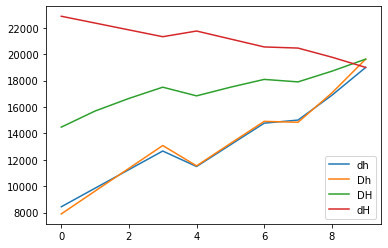

In [14]:
for k in BDE_models.keys():
    plt.plot(BDE_models[k].nbfe, label = k)
plt.legend()

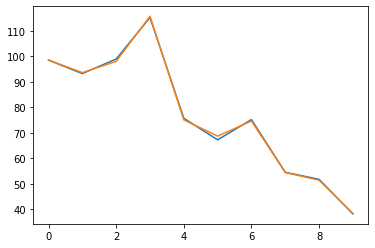

In [15]:
# nbfe with av dist = 1
energies_d1 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_2/energies_single.txt')
nrep_d1 = []
for i in range(len(nuc_charges)):
    for j in range(i, len(nuc_charges)):
        nrep_d1.append(nuc_charges[i]*nuc_charges[j])
nrep_d1 = np.array(nrep_d1)
energies_d1[:,1] = energies_d1[:,0] - nrep_d1
energies_d1[:,2] = nrep_d1
d1 = BDE(energies_d1, nuc_charges)
BDE_models['d1'] = d1

d1.linear_fit()
plt.plot(d1.bde)
plt.plot(d1.bde_predicted)

In [16]:
d1.linear_mae

0.5134766712986704